# Optimizing image generation prompting using CLIP scores
In this notebook we will compare different prompts and measure a text-to-image similarity metric: The [CLIP score](https://lightning.ai/docs/torchmetrics/stable/multimodal/clip_score.html).

In [1]:
import torch
import numpy as np
from skimage.io import imread
import stackview
from diffusers import DiffusionPipeline, AutoencoderTiny
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This is how the metric is initialized

In [2]:
from torchmetrics.multimodal.clip_score import CLIPScore
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

We start with this example image.

StackViewNDArray([[[176, 178, 179],
                   [175, 178, 178],
                   [177, 177, 180],
                   ...,
                   [182, 186, 188],
                   [185, 188, 191],
                   [191, 194, 197]],

                  [[178, 180, 181],
                   [178, 179, 181],
                   [178, 180, 181],
                   ...,
                   [185, 189, 192],
                   [187, 191, 192],
                   [191, 195, 198]],

                  [[181, 183, 185],
                   [180, 182, 183],
                   [180, 181, 183],
                   ...,
                   [190, 193, 196],
                   [189, 193, 196],
                   [192, 195, 198]],

                  ...,

                  [[125,  91,  66],
                   [124,  90,  65],
                   [123,  89,  65],
                   ...,
                   [137,  92,  64],
                   [136,  91,  62],
                   [135,  89,  61]],

                  [[122,  88,  64],
                   [121,  87,  63],
                   [121,  87,  63],
                   ...,
                   [142,  96,  68],
                   [142,  96,  68],
                   [139,  94,  65]],

                  [[120,  86,  62],
                   [120,  86,  60],
                   [119,  85,  61],
                   ...,
                   [144,  99,  70],
                   [144,  99,  70],
                   [142,  97,  68]]], dtype=uint8)
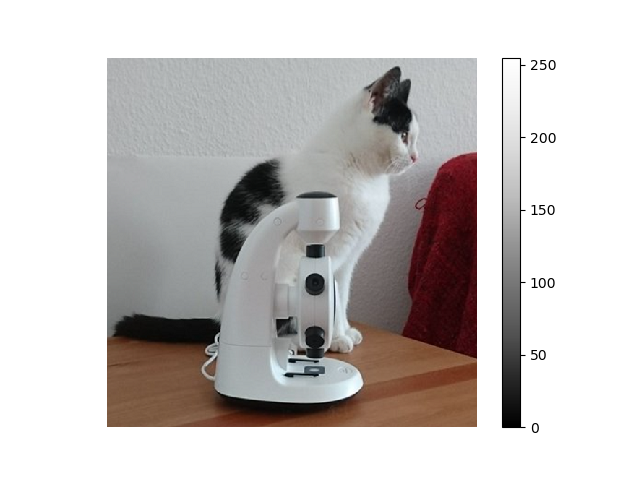
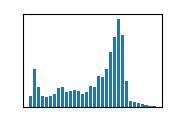

In [3]:
image = imread("data/real_cat.png")
stackview.insight(image)

In [4]:
score = metric(torch.as_tensor(image), "cat")
score.detach()

tensor(25.3473)

In [5]:
score = metric(torch.as_tensor(image), "microscope")
float(score.detach())

30.786285400390625

## Recap: Generating images
We will now use a prompt to generate an image and will measure if it shows a cat.

In [6]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

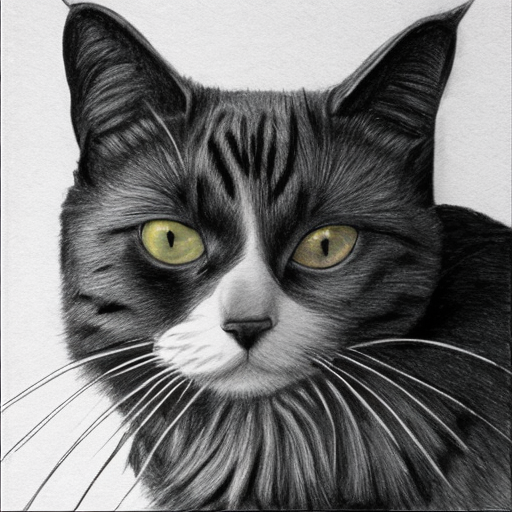

In [7]:
prompt = "Draw a realistic photo of a cat."

cat = pipe(prompt).images[0]
cat

In [8]:
score = metric(torch.as_tensor(np.array(cat)), "cat")
np.asarray(score.detach())

array(26.65498, dtype=float32)

## Benchmarking prompts
To compare different prompts quantitatively, we run image generation in a loop and measure their quality. As a control, we also generate images that show dogs and no cats.

Using this strategy, we can do prompt engineering / prompt optimization in an informed way.

In [9]:
num_attempts = 10
prompts = ["Draw a realistic photo of a cat.", 
           "Draw a cat",
           "cat", 
           "Draw a realistic photo of a dog."]

data = {"prompt":[],
        "score":[]}
for prompt in prompts:
    for i in range(num_attempts):
        image = pipe(prompt, disable_tqdm=True).images[0]

        score = metric(torch.as_tensor(np.array(image)), "cat")
        data["score"].append(float(score.detach()))
        data["prompt"].append(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
data = pd.DataFrame(data)
data

,prompt,score
0,Draw a realistic photo of a cat.,27.656635
1,Draw a realistic photo of a cat.,26.781824
2,Draw a realistic photo of a cat.,27.483803
3,Draw a realistic photo of a cat.,26.999044
4,Draw a realistic photo of a cat.,27.809370
5,Draw a realistic photo of a cat.,27.048084
6,Draw a realistic photo of a cat.,28.171909
7,Draw a realistic photo of a cat.,25.953665
8,Draw a realistic photo of a cat.,26.899948
9,Draw a realistic photo of a cat.,30.001472


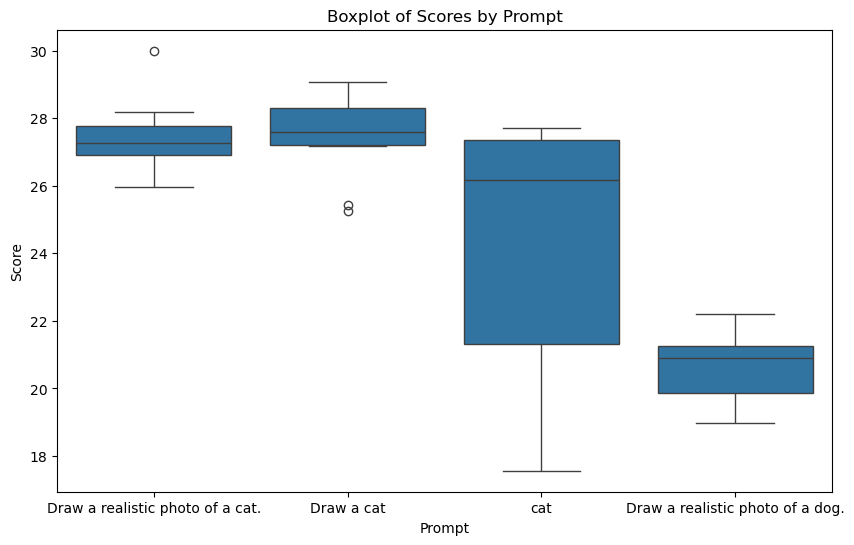

In [11]:
# Plotting the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='prompt', y='score', data=data)
plt.title('Boxplot of Scores by Prompt')
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.show()

## Exercise
Append more prompts to the list above. Attempt to improve the score for the image showing a cat.

Measure which of the prompts produces the most photorealistic images. 